In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'


In [7]:
def main_calcs(workdir, file_name, peaks_dataframe, peak_name="Peak_name", signal_name="SN",
               window=100, bias = range(-10000,10001,20), experiments_for_std=4000, chroms_for_stat=None):
    
    if chroms_for_stat is None:
        chroms_for_stat = peaks_dataframe[1].unique()
    
    methylation = pd.read_csv(workdir + file_name + '.txt', header=None, sep='\t',skiprows=1)
    
    signal_window_mean = {}
    for i in bias:
        signal_window_mean[i] = np.zeros(3, dtype=int)

    chr_amount = chroms_for_stat.shape[0]
    for (k,chrname) in enumerate(chroms_for_stat):
        chrsize = int(chrom_sizes[chrom_sizes[0]==chrname][1])
        
        print("                                                                               ", end='\r')
        print("Making calculations for: ", chrname, "(", k+1, "/", chr_amount, ")", end='\r')
        
        genome_field_methylated = np.zeros(chrsize) # creating the 0 methylated chromosome
        genome_field_reads = np.zeros(chrsize)
        
        meth_pos = methylation[methylation[0]==chrname]

        genome_field_methylated[meth_pos[1]] = meth_pos[3] # import methylation
        genome_field_reads[meth_pos[1]] = meth_pos[3]+meth_pos[4]

        genome_field_methylated = np.convolve(genome_field_methylated, np.ones((window,)), mode='same') # sliding window sum of methylation
        genome_field_reads = np.convolve(genome_field_reads, np.ones((window,)), mode='same') # sliding window sum of reads

        for p in np.array(peaks_dataframe[peaks_dataframe[0]==chrname][1]):
            for i in bias:
                if (p+i > 0) and (p+i < chrsize):
                    reads = genome_field_reads[p+i]
                    if reads!=0:
                        signal_window_mean[i] += np.array([genome_field_methylated[p+i], reads, 1], dtype=int) # collecting stat with respect to Atac-seq
                    
    signal_peaks = []
    genome_average = []
    ave_meth = methylation[3].sum()
    ave_unmeth = methylation[4].sum()

    print("                                                                               ", end='\r')
    print("Conducting an experiment with distributions for STD calculations", end='\r')

    for i in signal_window_mean:
        dist_meth = signal_window_mean[i][0]
        dist_unmeth = signal_window_mean[i][1]-signal_window_mean[i][0]
        distribution = np.array([100]*int(dist_meth/(dist_meth+dist_unmeth+1)*10000) + [0]*int(dist_unmeth/(dist_meth+dist_unmeth+1)*10000)) #create an array with the same distribution as shuold be at "x" shift
        experiments = np.random.randint(distribution.shape[0], size=(experiments_for_std, signal_window_mean[i][2]))
        destd = distribution[experiments].mean(axis=1).std()
        
        signal_peaks += [[i,signal_window_mean[i][0]/signal_window_mean[i][1]*100, destd,signal_window_mean[i][2]]]
        
        distribution = np.array([100]*int(ave_meth/(ave_meth+ave_unmeth)*10000) + [0]*int(ave_unmeth/(ave_meth+ave_unmeth)*10000))
        experiments = np.random.randint(distribution.shape[0], size=(experiments_for_std, signal_window_mean[i][2]))
        
        genome_average += [[i, distribution[experiments].mean(axis=1).mean(), distribution[experiments].mean(axis=1).std(), signal_window_mean[i][2]]]

    signal_peaks = np.array(signal_peaks)
    genome_average = np.array(genome_average)

    pd.DataFrame(signal_peaks).to_csv(workdir + file_name + '.' + signal_name + '.' + peak_name + ".graph", sep='\t', header=False, index=False)
    pd.DataFrame(genome_average).to_csv(workdir + file_name + '.' + signal_name + '.' + peak_name + '.GenomeAverage.graph', sep='\t', header=False, index=False)

project_name='NoMe-seq'
def draw_graphs(workdir, file_name, peak_name=project_name +"."+ 'top10%1', signal_name='test'):
    fig, ax = plt.subplots(figsize=(20, 20))
    
    for s in signal_name:
        signal_peaks = np.array(pd.read_csv(workdir + file_name + '.' + s + '.' + peak_name + ".graph", sep='\t', header=None))
        genome_average = np.array(pd.read_csv(workdir + file_name + '.' + s + '.' + peak_name + '.GenomeAverage.graph', sep='\t', header=None))
        ax.plot(signal_peaks[:,0], signal_peaks[:,1], label=file_name+'.'+s)
        ax.plot(genome_average[:,0], genome_average[:,1], "k--", label=file_name+'.'+s+' genome average')

        # Fill area when income > expenses with green
        ax.fill_between(
            signal_peaks[:,0],
            signal_peaks[:,1] + 3*signal_peaks[:,2],
            signal_peaks[:,1] - 3*signal_peaks[:,2],  
            interpolate=True, alpha=0.2, 
            label="3*sigma" + s
        )
        ax.fill_between(
            genome_average[:,0],
            genome_average[:,1] + 3*genome_average[:,2],
            genome_average[:,1] - 3*genome_average[:,2],  
            interpolate=True, alpha=0.1, color='black',
            label="3*sigma genome average" + s
        )

    ax.legend()
    plt.savefig(workdir + file_name + '.' + '.' + peak_name + '.png')
    
def draw_intersection(workdir, file_name,  peak_name=project_name +"."+ 'top10%1', signal_name='test'):
    fig, ax = plt.subplots(figsize=(10, 10))

    signal_peaks_plus = np.array(pd.read_csv(workdir + file_name + '.' + signal_name[0] + '.' + peak_name + ".graph", sep='\t', header=None))
    signal_peaks_minus = np.array(pd.read_csv(workdir + file_name + '.' + signal_name[1] + '.' + peak_name + ".graph", sep='\t', header=None))

    overlap_array = np.zeros_like(signal_peaks_minus[:,0])
    overlap_noize = np.zeros_like(signal_peaks_minus[:,0])
    for (i, (mu_plus, std_plus)) in enumerate(signal_peaks_plus[:,1:3]):
        mu_minus = signal_peaks_minus[i,1]
        std_minus = signal_peaks_minus[i,2]
        overlap_array[i] += NormalDist(mu=mu_minus*100, sigma=std_minus).overlap(NormalDist(mu=mu_plus*100, sigma=std_plus))

    ax.plot(signal_peaks_plus[:,0], overlap_array, color="blue")

def average_calcs(workdir, file_name,peaks_dataframe=TSS, peak_name=project_name +"."+ 'top10%1', signal_name='test', experiments_for_std=4000):
    
    methylation = pd.read_csv(workdir + file_name +  '.' + signal_name + '.counts', header=None, sep='\t')
    
    signal_peaks = np.array(pd.read_csv(workdir + file_name + '.' + signal_name + '.' + peak_name + ".graph", sep='\t', header=None))
                    
    genome_average = []
    print("                                                                               ", end='\r')
    print("Conducting an experiment with distributions for STD calculations (Average)", end='\r')
    for i in signal_peaks:
        distribution = np.array([100]*(methylation[2].sum()) + [0]*(methylation[3].sum()))
        experiments = np.random.randint(distribution.shape[0], size=(experiments_for_std, int(i[3])))
        exp_means = []
        for experiment in experiments:
            exp_means += [distribution[experiment].mean()]
        exp_means = np.array(exp_means)
        genome_average += [[i[0],exp_means.mean(),exp_means.std(),i[3]]]

    genome_average = np.array(genome_average)

    pd.DataFrame(genome_average).to_csv(workdir + file_name + '.' + signal_name + '.' + peak_name + '.GenomeAverage.graph', sep='\t', header=False, index=False)

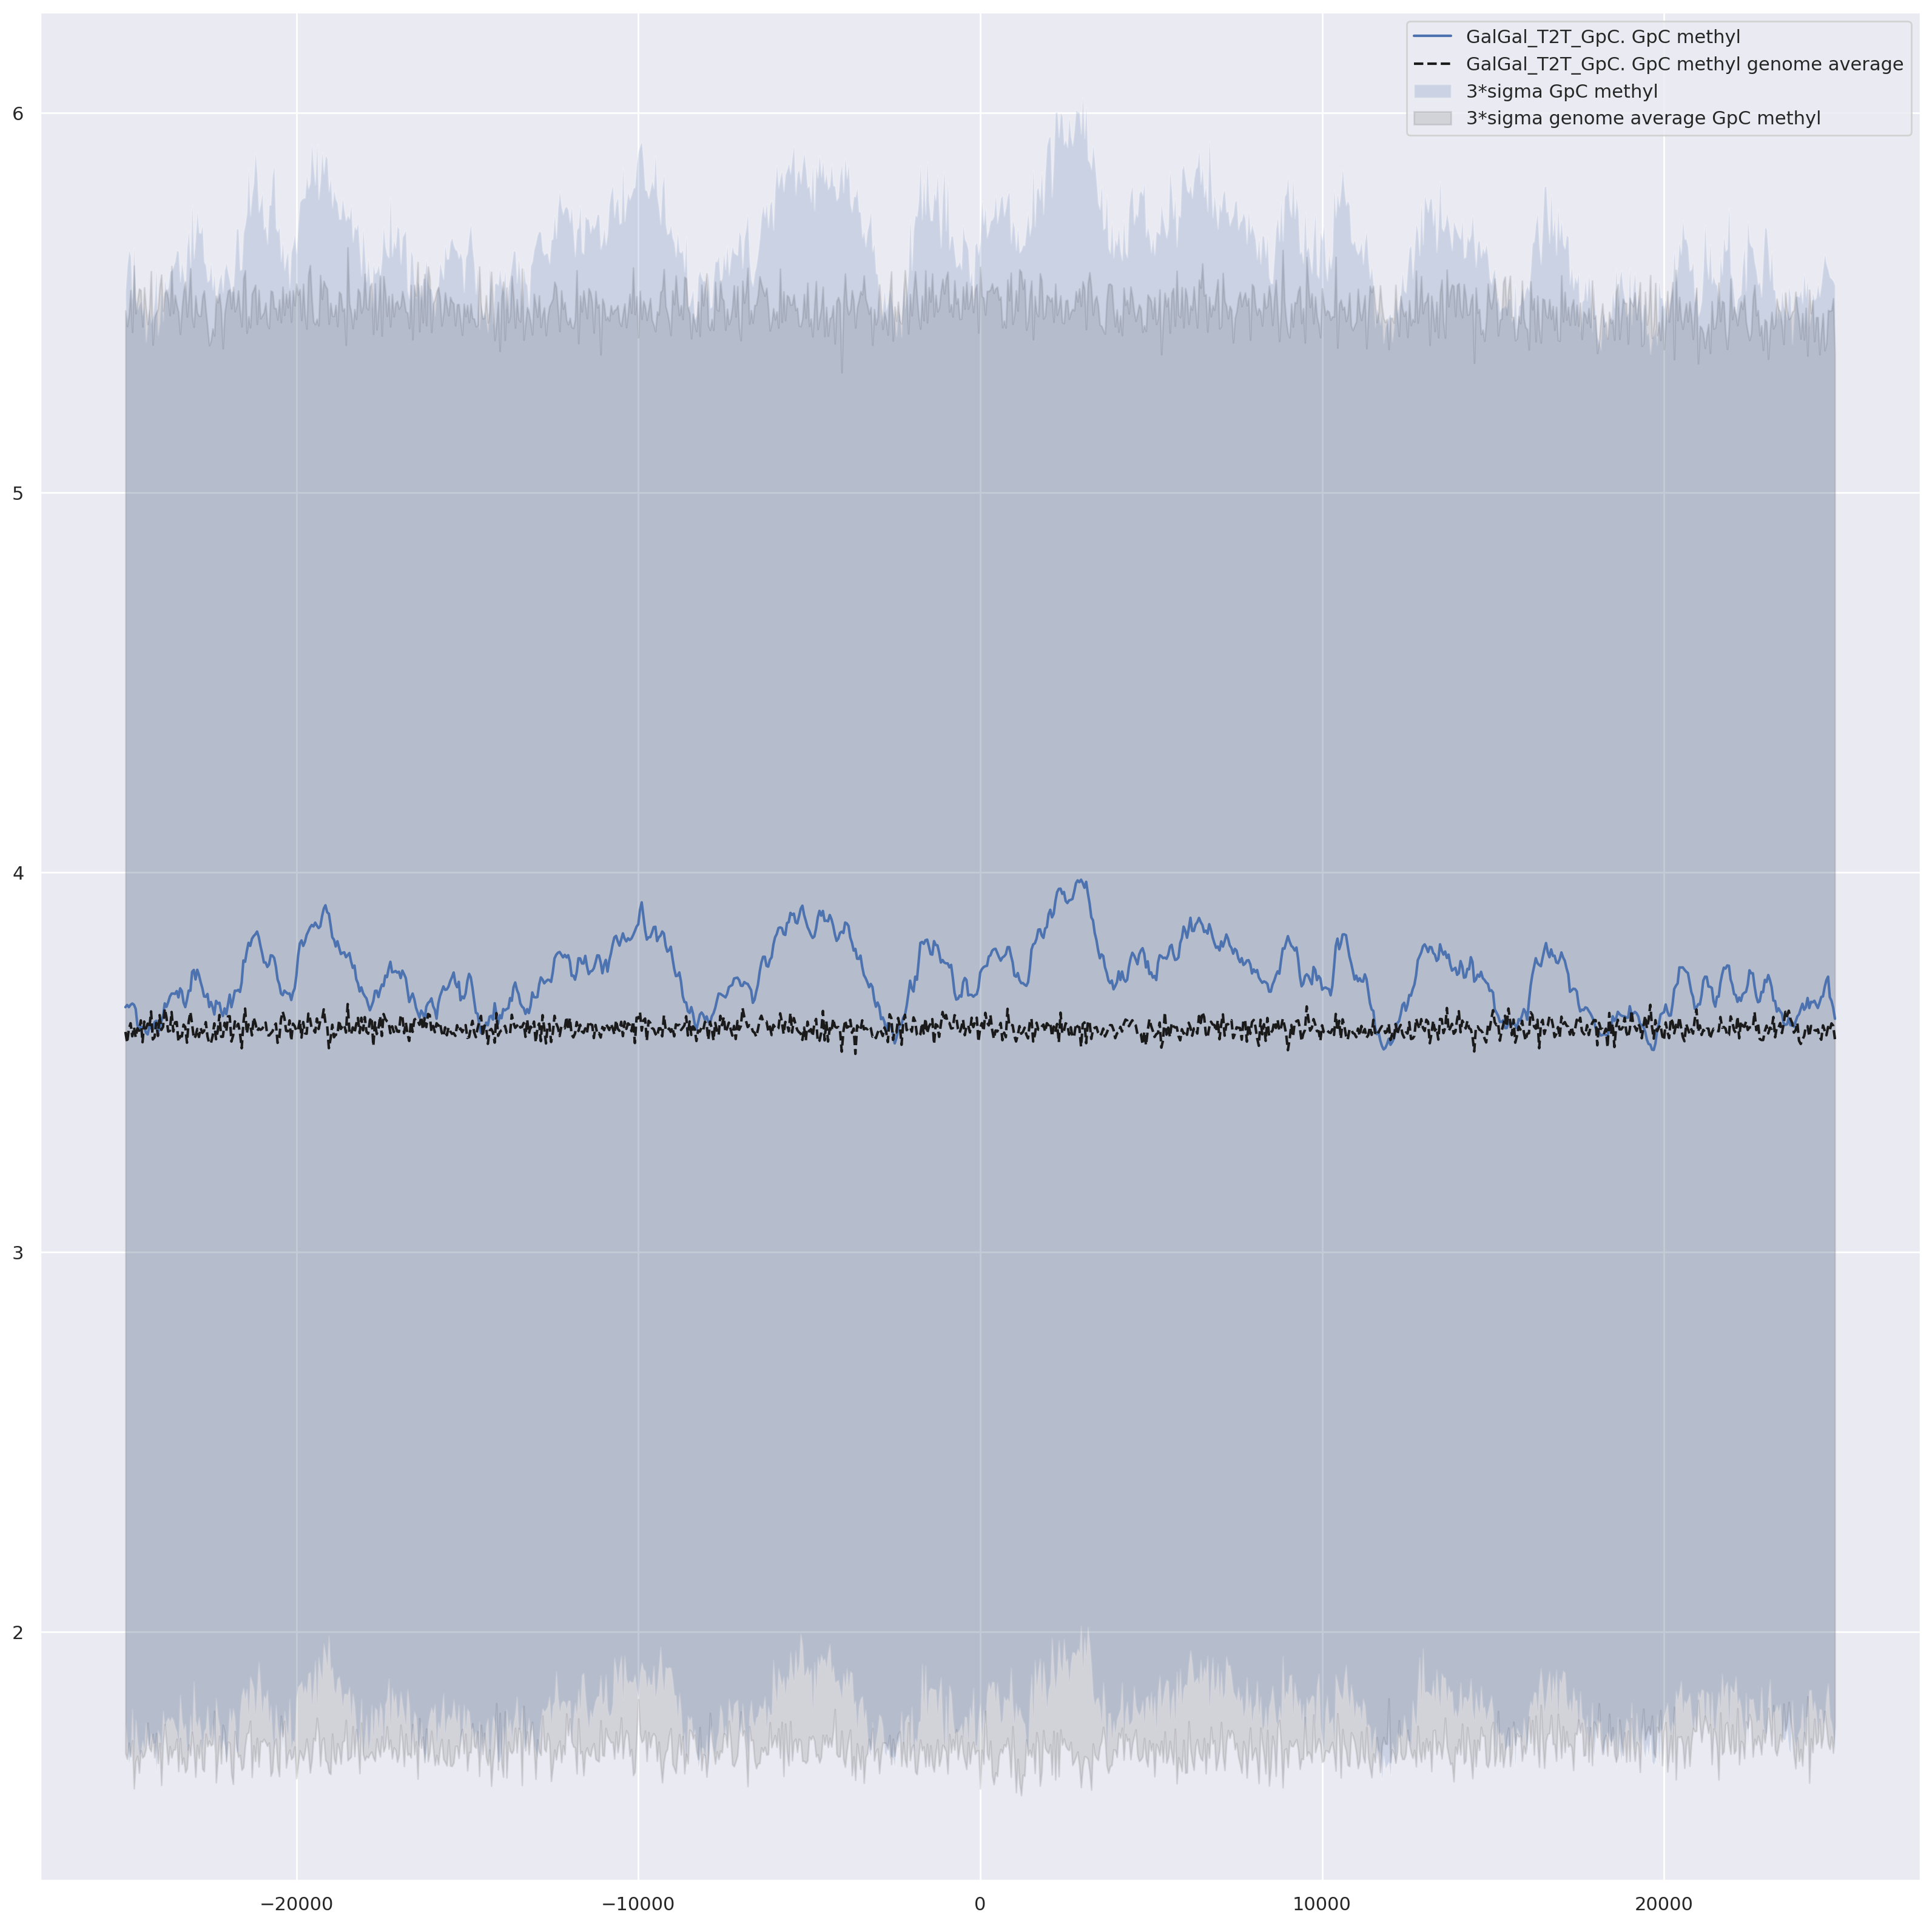

In [10]:
#%%time
# Для работы всех функций файлы bedGraph должны иметь следующий шаблон названия:
# {Project Name}.{Signal_name}.bedGraph.sorted - так как желательно отсортировать файл перед запуском

# Названия файлов до 1ой точки ({Project Name})
project_name='CpG_on_TADs'
#['bismaaark.NOMe.GpC_report']

# Рабочая директория
workdir = '/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/'

TSS = pd.read_csv(workdir + "TADs_less_2MB.bed", sep='\t', header=None)
file_name = 'GalGal_T2T_GpC'
chrom_sizes = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/GalGal_T2T.chrom.sizes', sep='\t', header=None)
values_to_remove = ['chr16', 'chr25', 'chr29', 'chr30', 'chr31', 'chr32', 'chr33', 'chr34', 'chr35', 'chr36', 'chr37', 'chr38', 'chrW','chrM']
chrom_sizes=chrom_sizes[~chrom_sizes[0].isin(values_to_remove)]


main_calcs(workdir, file_name, peaks_dataframe=TSS, peak_name=project_name +"."+ 'GpC', signal_name=' GpC methyl', 
        bias=range(-25000, 25001, 50), window=1000,
        chroms_for_stat=chrom_sizes[0], experiments_for_std=1000)
draw_graphs(workdir, file_name, peak_name=project_name +"."+ 'GpC', signal_name=[' GpC methyl'])

In [56]:
from Bio import SeqIO
import pandas as pd

# Чтение файла GalGal_T2T.fa
filename = "/data/aapopov/Projects/ChickenOocyt/Hi-C_CEF/genome/GalGal_T2T.fa"
sequences = SeqIO.parse(filename, "fasta")

# Инициализация списка для хранения результатов
result_list = []

# Цикл по всем последовательностям
for seq_record in sequences:
    # Получение идентификатора (chr)
    chr = seq_record.description.split()[0]
    # Объединение строк
    seq = str(seq_record.seq).upper()
    # Разделение на списки по 10 элементов
    seq_list = [seq[i:i+10] for i in range(0, len(seq), 10)]
    # Подсчет G и C в каждом элементе списка
    gc_count = [s.count('G') + s.count('C') for s in seq_list]
    # Повторение chr
    chr_list = [chr] * len(gc_count)
    # Создание DataFrame
    df = pd.DataFrame({
        'chr': chr_list,
        'start': range(10, 10*(len(gc_count)+1), 10),
        'filler': ['.']*len(gc_count),
        'gc_count': gc_count,
        'mod': [abs(gc-10) for gc in gc_count]
    })
    # Добавление результатов в общий список
    result_list.append(df)

# Объединение всех результатов в один DataFrame
final_df = pd.concat(result_list, ignore_index=True)
final_df.to_csv('GalGal_T2T_GC_biopython.txt',sep='\t',index=False)
# Вывод результатов
print(final_df)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chr23
chr24
chr25
chr26
chr27
chr28
chr29
chr30
chr31
chr32
chr33
chr34
chr35
chr36
chr37
chr38
chrW
chrZ
chrM
            chr  start filler  gc_count  mod
0          chr1     10      .         4    6
1          chr1     20      .         5    5
2          chr1     30      .         6    4
3          chr1     40      .         4    6
4          chr1     50      .         5    5
...         ...    ...    ...       ...  ...
110092823  chrM  16750      .         1    9
110092824  chrM  16760      .         4    6
110092825  chrM  16770      .         5    5
110092826  chrM  16780      .         4    6
110092827  chrM  16790      .         1    9

[110092828 rows x 5 columns]


In [53]:
import pandas as pd

# Чтение файла и инициализация переменных
filename = '/data/aapopov/Projects/ChickenOocyt/Hi-C_CEF/genome/GalGal_T2T.fa'
output_data = []

# Открытие файла и обработка строк
with open(filename, 'r') as file:
    chr_name = ""
    sequence = ""
    for line in file:
        line = line.strip()
        if line.startswith('>'):
            if chr_name and sequence:
                sequence = sequence.upper()
                sequence_parts = [sequence[i:i+10] for i in range(0, len(sequence), 10)]
                count_gc = [s.count('G') + s.count('C') for s in sequence_parts]
                repeated_chr = [chr_name] * len(sequence_parts)
                if 
                df = pd.DataFrame({'chr': repeated_chr,
                                   'value': list(range(10, len(sequence) + 1, 10)),
                                   'dots': ['.'] * len(sequence_parts),
                                   'count_GC': count_gc,
                                   'module': [abs(c-10) for c in count_gc]})
                output_data.append(df)
            chr_name = line[1:]
            sequence = ""
        else:
            sequence += line

# Создание итогового DataFrame
result_df = pd.concat(output_data, ignore_index=True)
print(result_df)
result_df.to_csv('GalGal_T2T_GC.txt',sep='\t',index=False)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



20004451
20004451
20004451
20004451
20004451


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



15212782
15212782
15212782
15212782
15212782


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



11237724
11237724
11237724
11237724
11237724


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



9136405
9136405
9136405
9136405
9136405


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



5947305
5947305
5947305
5947305
5947305


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3615847
3615847
3615847
3615847
3615847


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



3643982
3643982
3643982
3643982
3643982


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2959415
2959415
2959415
2959415
2959415


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2396684
2396684
2396684
2396684
2396684


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2160626
2160626
2160626
2160626
2160626


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1982231
1982231
1982231
1982231
1982231


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2059134
2059134
2059134
2059134
2059134


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1925399
1925399
1925399
1925399
1925399


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1625974
1625974
1625974
1625974
1625974


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1352939
1352939
1352939
1352939
1352939


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1132212
1132212
1132212
1132212
1132212


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1219940
1219940
1219940
1219940
1219940


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1129572
1129572
1129572
1129572
1129572


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1536117
1536117
1536117
1536117
1536117


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



710656
710656


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



859185
859185
859185
859185


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1415183
1415183
1415183
1415183
1415183


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



8773586
8773586
8773586
8773586
8773586
            chr     value dots  count_GC  module
0          chr1        10    .         4       6
1          chr1        20    .         5       5
2          chr1        30    .         6       4
3          chr1        40    .         4       6
4          chr1        50    .         5       5
...         ...       ...  ...       ...     ...
110091144  chrZ  87735820    .         5       5
110091145  chrZ  87735830    .         5       5
110091146  chrZ  87735840    .         6       4
110091147  chrZ  87735850    .         5       5
110091148  chrZ  87735860    .         2       8

[110091149 rows x 5 columns]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
as_strided = np.lib.stride_tricks.as_strided

# Загрузка данных из файлов
file1 = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/TAD_boundaries.bed', sep='\t', header=None, names=['Chromosome', 'Start', 'End'])
file2 = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/bismark_PICO.NOMe.CpG_report.txt', sep=' ', header=None, names=['Chromosome', 'Start', 'End', 'Signal'])
print(file1)
print(file2)
# Задание параметров скользящего окна
window_size = 500  # размер окна
step_size = 100  # шаг
sliding_range = 3000  # диапазон скольжения

# Функция для расчета среднего значения сигнала в окне
def calculate_average_signal(chromosome, position):
    sub_df = file2[(file2['Chromosome'] == chromosome) & (file2['Start'] >= position - window_size) & (file2['End'] <= position + window_size)]
    print(sub_df['Signal'].mean())
    return sub_df['Signal'].mean()

# Расчет средних значений сигнала для каждого региона из первого файла
list_signals = []
print(len(file1['Chromosome']))
for i, row in file1.iterrows():
    print(row)
    if i % 100 == 0:
        print(i)
    mid_point = (row['Start'] + row['End']) / 2
    start = mid_point - sliding_range
    end = mid_point + sliding_range
    points = np.arange(start, end, step_size)
    signals = [calculate_average_signal(row['Chromosome'], pos) for pos in points]
    list_signals.append(np.array(signals))
print(list_signals)
mean_signals=np.mean(list_signals,axis=0)
# Визуализация результатов
plt.plot(np.arange(-sliding_range, sliding_range, step_size), mean_signals)
plt.xlabel('Расстояние')
plt.ylabel('Среднее значение сигнала')
plt.show()


    Chromosome     Start       End
0        chr10   1984000   2480000
1        chr10   2480000   3184000
2        chr10   3184000   3808000
3        chr10   3808000   4560000
4        chr10   4560000   4875000
..         ...       ...       ...
966       chr9  19664000  20240000
967       chr9  20240000  21248000
968       chr9  21248000  22224000
969       chr9  22224000  23152000
970       chr9  23152000  23920000

[971 rows x 3 columns]
                               Chromosome  Start  End  Signal
0            chr1\t6715\t-\t1\t0\tCG\tCGG    NaN  NaN     NaN
1            chr1\t6733\t-\t1\t0\tCG\tCGG    NaN  NaN     NaN
2            chr1\t6757\t-\t0\t1\tCG\tCGG    NaN  NaN     NaN
3            chr1\t6776\t-\t1\t0\tCG\tCGG    NaN  NaN     NaN
4            chr1\t6800\t-\t1\t0\tCG\tCGG    NaN  NaN     NaN
...                                   ...    ...  ...     ...
8861276  chrZ\t87729398\t-\t0\t1\tCG\tCGG    NaN  NaN     NaN
8861277  chrZ\t87729431\t-\t1\t0\tCG\tCGG    NaN  NaN     Na

KeyboardInterrupt: 

In [79]:
data=pd.read_csv('GalGal_T2T_GC_biopython.txt',sep='\t')
chrom=pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Hi-C_CEF/genome/GalGal_T2T.chrom.sizes', sep='\t', header=None)
redact=[]
for chr in chrom[0]:
    data_chrom=data[data['chr']==chr]
    data_end=data_chrom[data_chrom['start']>int(chrom[chrom[0]==chr][1])]
    if not data_end.empty: 
        data_end['mod']=int(data_end['mod']-(data_end['start']-int(chrom[chrom[0]==chr][1])))
        data_end['start']=int(chrom[chrom[0]==chr][1])
        data_res = pd.concat([data_chrom.iloc[:-1], data_end], axis=0, ignore_index=True)
        print(data_res)
    redact.append(data_res)
res=pd.concat(redact,ignore_index=True)
res.to_csv('GalGal_T2T_GC_content.txt',sep='\t',index=False)

           chr      start filler  gc_count  mod
0         chr1         10      .         4    6
1         chr1         20      .         5    5
2         chr1         30      .         6    4
3         chr1         40      .         4    6
4         chr1         50      .         5    5
...        ...        ...    ...       ...  ...
20004446  chr1  200044470      .         6    4
20004447  chr1  200044480      .         4    6
20004448  chr1  200044490      .         5    5
20004449  chr1  200044500      .         6    4
20004450  chr1  200044509      .         3    6

[20004451 rows x 5 columns]
           chr      start filler  gc_count  mod
0         chr2         10      .         6    4
1         chr2         20      .         5    5
2         chr2         30      .         4    6
3         chr2         40      .         5    5
4         chr2         50      .         4    6
...        ...        ...    ...       ...  ...
15212777  chr2  152127780      .         5    5
15212778  c

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm 
import random

# Загрузка данных из файлов
file1 = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/TAD_boundaries.bed', sep='\t', header=None, names=['chr', 'st', 'end'])
file2 = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/bismark_PICO.NOMe.CpG_report.txt', sep='\t', header=None, usecols=[0,1,3],names=['chr','st','met_count'])
print(file1)
print(file2)
# Задание параметров скользящего окна
sliding_range = 3000
window_size = 500 
step_size = 20
values_to_remove = ['chr16', 'chr25', 'chr29', 'chr30', 'chr31', 'chr32', 'chr33', 'chr34', 'chr35', 'chr36', 'chr37', 'chr38', 'chrW','chrM']
file2=file2[~file2['chr'].isin(values_to_remove)]
df=file1.copy()


def average_signal_calculate(df, file2, sliding_range = 3000, window_size = 500, step_size = 100):
    len_df=len(df)
    df['mid_point'] = (df['st'] + df['end']) / 2
    df['slide_left'] =  df['mid_point'].astype(int) - sliding_range 
    df['slide_right'] = df['mid_point'].astype(int) + sliding_range
    
    mean_signals=np.zeros(len(range(-sliding_range, sliding_range, step_size)))
    for num, chrom in enumerate(pd.unique(file2['chr'])):
        file_slice=file2[file2['chr']==chrom]
        print(file_slice)
        keys_signal=dict(zip(file_slice['st'],file_slice['met_count']))
        vectorized_mapping= np.vectorize(keys_signal.get)
        df_slice=df[df['chr']==chrom]
        results_per_region=np.zeros([len(df_slice), len(range(-sliding_range, sliding_range, step_size))])
        for index, row in df_slice.iterrows():
            result = []
            all_average_result = np.zeros(len(range( row['slide_left'], row['slide_right'], step_size)))
            for t,i in enumerate(range(row['slide_left'], row['slide_right'], step_size)):
                window = np.arange(i, i + window_size)
                print(t)
                signals = vectorized_mapping(window)
                signals_without_none = np.where(signals == None, 0, signals)
                
                score=(np.sum(signals_without_none)/ window_size)
                all_average_result[t]=score
            results_per_region[index,:]=all_average_result
        mean_signals=np.sum(results_per_region,axis=0)/len_df
    mean_signals+=mean_signals
    
        
    return mean_signals

def calc_random_control(bed, bedGraph_chroms):
     chroms = bedGraph_chroms
     random_control = pd.DataFrame(columns=["chrom", "st", "end"])
     for chrom in chroms: 
        starts = bed.query('chr==@chrom')["st"].values
        ends = bed.query('chr==@chrom')["end"].values
        region_lengths = ends - starts
        inter_region_lengths = starts[1:] - ends[:-1] # well done!
        #assert inter_region_lengths.min() > 0 # good point!
    
        random.shuffle(region_lengths)
        random.shuffle(inter_region_lengths)
        
        new_starts = np.insert(np.cumsum(region_lengths[:-1] + inter_region_lengths)+starts.min(), 0, starts.min())
    
        #assert (new_starts[1:] - new_starts[:-1]).min() >= 0
        
        new_ends = new_starts +  region_lengths
    
        ###
        chroms = [chrom] * len(starts)
    
        assert len(set(chroms))==1
     
    
        random_for_chrom = pd.DataFrame({'chr': chroms, 'st': new_starts, 'end': new_ends})
        random_control = pd.concat([random_control, random_for_chrom], axis=0, ignore_index=True)
     return random_control

experiment_average_signal=average_signal_calculate(file1, file2, sliding_range, window_size, step_size)

random_control_list=[]
for i in tqdm.tqdm(range(10)):
    random_control=calc_random_control(file1, pd.unique(file2['chr']))
    random_control_signal=average_signal_calculate(random_control, file2, sliding_range, window_size, step_size)
    random_control_list.append(random_control_signal)


random_control_list=np.array(random_control_list)
control_mean=np.average(random_control_list,axis=0)
control_std=np.std(random_control_list,axis=0)
distances=np.arange(-sliding_range, sliding_range, step_size)
plt.plot(distances, experiment_average_signal, lw=0.5)
plt.plot(distances, control_mean, color='r',lw=0.5)
plt.plot(distances, control_mean+3*control_std, '--', color='r',lw=0.5)
plt.plot(distances, control_mean-3*control_std,'--', color='r',lw=0.5)
plt.fill_between(distances,control_mean+3*control_std,control_mean-3*control_std,color='r',alpha=0.2)
plt.xlabel("Distance to centre (bp)")
plt.ylabel("Average signal")
plt.axvline(linestyle ='--',color='black')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

       chr        st       end
0    chr10   1984000   2480000
1    chr10   2480000   3184000
2    chr10   3184000   3808000
3    chr10   3808000   4560000
4    chr10   4560000   4875000
..     ...       ...       ...
966   chr9  19664000  20240000
967   chr9  20240000  21248000
968   chr9  21248000  22224000
969   chr9  22224000  23152000
970   chr9  23152000  23920000

[971 rows x 3 columns]
          chr        st  met_count
0        chr1      6715          1
1        chr1      6733          1
2        chr1      6757          0
3        chr1      6776          1
4        chr1      6800          1
...       ...       ...        ...
8861276  chrZ  87729398          0
8861277  chrZ  87729431          1
8861278  chrZ  87729532          1
8861279  chrZ  87729996          3
8861280  chrZ  87730033          1

[8861281 rows x 3 columns]
          chr         st  met_count
0        chr1       6715          1
1        chr1       6733          1
2        chr1       6757          0
3        chr

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [2]:
import pandas as pd
data=pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/chicken.v23.gff',sep='\t', header=None, skiprows=1)
gene_data=pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/OB.sorted_genes.ent', sep='\t', header=None, skiprows=1)
exons=data[data[2]=='exon']
print(exons)
introns=gene_data[gene_data[2]=='intron']
print(introns)
UTR_5=data[data[2]=='five_prime_UTR']
print(UTR_5)
UTR_3=data[data[2]=='three_prime_UTR']
print(UTR_3)

exons=exons.iloc[:,[0,3,4]]
introns=introns.iloc[:,[1,4,5]]
UTR_5=UTR_5.iloc[:,[0,3,4]]
UTR_3=UTR_3.iloc[:,[0,3,4]]
exons.to_csv('GalGal_T2T_exons.bed',sep='\t',header=None,index=False)
introns.to_csv('GalGal_T2T_introns.bed',sep='\t',header=None,index=False)
UTR_5.to_csv('GalGal_T2T_UTR_5.bed',sep='\t',header=None,index=False)
UTR_3.to_csv('GalGal_T2T_UTR_3.bed',sep='\t',header=None,index=False)


           0        1     2         3         4  5  6  7   
1       chr1  Liftoff  exon     25377     25725  .  +  .  \
2       chr1  Liftoff  exon     25989     26134  .  +  .   
3       chr1  Liftoff  exon     26618     27064  .  +  .   
11      chr1  Liftoff  exon     27371     27545  .  +  .   
12      chr1  Liftoff  exon     28103     28584  .  +  .   
...      ...      ...   ...       ...       ... .. .. ..   
880406  chrZ  Liftoff  exon  87508698  87508757  .  -  .   
880407  chrZ  Liftoff  exon  87590026  87590227  .  -  .   
880408  chrZ  Liftoff  exon  87631319  87631464  .  -  .   
880409  chrZ  Liftoff  exon  87712542  87712649  .  -  .   
880410  chrZ  Liftoff  exon  87713010  87713050  .  -  .   

                                                        8  
1       ID "ck_00000001-RA.u1"; Parent "ck_00000001-RA...  
2       ID "ck_00000001-RA.u4"; Parent "ck_00000001-RA...  
3       ID "ck_00000001-RA.u6"; Parent "ck_00000001-RA...  
11      ID "ck_00000002-RA.u9"; Parent 

In [ ]:
!/data/aapopov/Projects/ChickenOocyt/Oocytes_average_TAD/Insualtion.sh

INFO:coolpuppy:Rescaling with rescale_flank = 2.0 to 99x99 pixels
INFO:coolpuppy:('chr1', 'chr1'): 6496
INFO:coolpuppy:('chr2', 'chr2'): 4386
INFO:coolpuppy:('chr3', 'chr3'): 3754
INFO:coolpuppy:('chr4', 'chr4'): 3558
INFO:coolpuppy:('chr5', 'chr5'): 2885
INFO:coolpuppy:('chr6', 'chr6'): 1584
INFO:coolpuppy:('chr7', 'chr7'): 1853
INFO:coolpuppy:('chr8', 'chr8'): 1712
INFO:coolpuppy:('chr9', 'chr9'): 1352
INFO:coolpuppy:('chr10', 'chr10'): 1278
INFO:coolpuppy:('chr11', 'chr11'): 1099
INFO:coolpuppy:('chr12', 'chr12'): 1040
INFO:coolpuppy:('chr13', 'chr13'): 1180
INFO:coolpuppy:('chr14', 'chr14'): 1292
INFO:coolpuppy:('chr15', 'chr15'): 1079
INFO:coolpuppy:('chr16', 'chr16'): 334
INFO:coolpuppy:('chr17', 'chr17'): 884
INFO:coolpuppy:('chr18', 'chr18'): 871
INFO:coolpuppy:('chr19', 'chr19'): 1046
INFO:coolpuppy:('chr20', 'chr20'): 1053
INFO:coolpuppy:('chr21', 'chr21'): 768
INFO:coolpuppy:('chr22', 'chr22'): 531
INFO:coolpuppy:('chr23', 'chr23'): 758
INFO:coolpuppy:('chr24', 'chr24'): 525

In [10]:
data=pd.read_csv('./GalGal_T2T_CpG.txt',sep='\t',header=None)
print(data)


            0         1  2  3  4   5    6
0        chr1      6715  -  1  0  CG  CGG
1        chr1      6733  -  1  0  CG  CGG
2        chr1      6757  -  0  1  CG  CGG
3        chr1      6776  -  1  0  CG  CGG
4        chr1      6800  -  1  0  CG  CGG
...       ...       ... .. .. ..  ..  ...
8861276  chrZ  87729398  -  0  1  CG  CGG
8861277  chrZ  87729431  -  1  0  CG  CGG
8861278  chrZ  87729532  +  1  0  CG  CGG
8861279  chrZ  87729996  -  3  1  CG  CGG
8861280  chrZ  87730033  -  1  1  CG  CGG

[8861281 rows x 7 columns]


In [28]:
import numpy as np
def calc_random_control(bed):
 print(bed)
 chroms = bed['chr']
 random_control = pd.DataFrame(columns=["chr", "start", "end"])
 chr_size = pd.read_csv('/data/aapopov/Projects/ChickenOocyt/Signal_on_TADS_regions/GalGal_T2T.chrom.sizes', sep='\t',header=None)
 for chrom in chroms:  
    starts = bed.query('chr==@chrom')["start"].values
    ends = bed.query('chr==@chrom')["end"].values
    region_lengths = ends - starts
    new_starts=np.random.randint(low=np.absolute(min(region_lengths)),high=(max(region_lengths)+chr_size[chr_size[0]==chrom][1]),size=starts.size)# well done!
    np.random.shuffle(region_lengths)

    new_ends=new_starts+region_lengths

     
    #assert inter_region_lengths.min() >= 0 # good point!
    '''
    random.shuffle(region_lengths)
    random.shuffle(inter_region_lengths)
    
    new_starts = np.insert(np.cumsum(region_lengths[:-1] + inter_region_lengths)+starts.min(), 0, starts.min())

    #assert (new_starts[1:] - new_starts[:-1]).min() >= 0
    
    new_ends = new_starts +  region_lengths
    '''
    chroms = [chrom] * len(new_starts)
    
 

    random_for_chrom = pd.DataFrame({'chr': chroms, 'start': new_starts, 'end': new_ends})
    random_control = pd.concat([random_control, random_for_chrom], axis=0, ignore_index=True)
    random_control = random_control.sort_values(by=['chr', 'start'])
 return random_control
bed=pd.read_csv('TADs_over_2MB.bed', sep='\t',header=None,names=['chr','start','end'])
result=calc_random_control(bed=bed)
print(result)

     chr     start       end
0   chr1   9200000  14048000
1   chr1  14350000  19344000
2   chr1  19424000  28550000
3   chr1  30925000  37525000
4   chr1  40925000  46080000
..   ...       ...       ...
57  chrZ  59984000  62416000
58  chrZ  62576000  64912000
59  chrZ  65856000  68144000
60  chrZ  69680000  72304000
61  chrZ  72608000  74704000

[62 rows x 3 columns]
      chr     start       end
0    chr1   2806667   5466667
1    chr1   2828325   5578325
2    chr1   2949154   5774154
3    chr1   3515417   8652417
4    chr1   3926708  10188708
..    ...       ...       ...
912  chrZ  90706530  92722530
913  chrZ  90774138  92870138
921  chrZ  90787502  93235502
914  chrZ  91488447  93856447
915  chrZ  91689824  93705824

[930 rows x 3 columns]
